In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title
plt.rc('axes', titlesize=20)  # fontsize of the figure title

# Surrogate Design Results

## Pricetaker Results

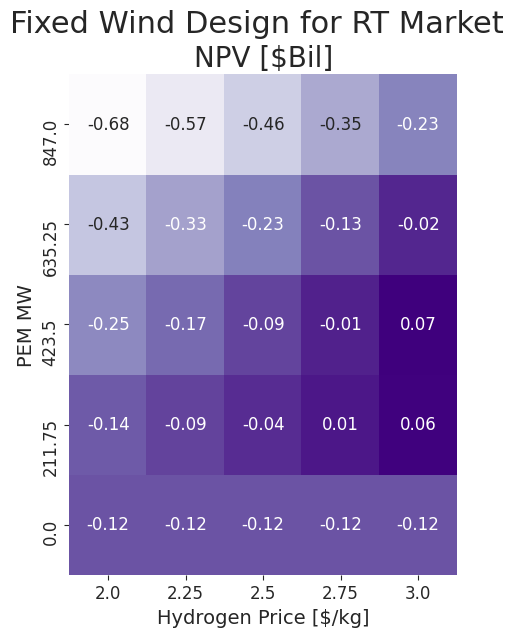

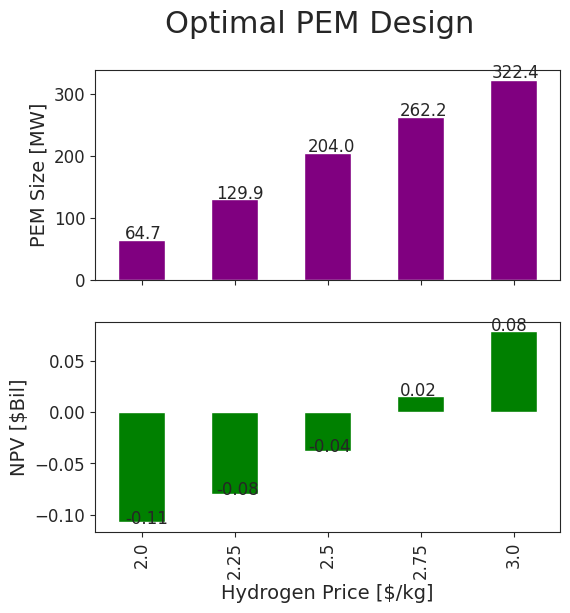

In [2]:
res_df = pd.read_csv("wind_PEM_RT_1000/wind_PEM_RT_1000.csv").drop('Unnamed: 0', axis=1)
res_df['NPV [$Bil]'] = res_df['NPV'] * 1e-9
colormaps = [sns.color_palette("Purples", as_cmap=True), # NPV
             sns.color_palette("Greens", as_cmap=True), # PEM
             ]

def plot_results(results, title):
    fig, axs = plt.subplots(1, 1, figsize=(5, 6.5), sharex=True, sharey=True)
    sns.heatmap(results.pivot_table(index='pem_mw', 
                                    columns="h2_price_per_kg", 
                                    values='NPV [$Bil]',
                                    aggfunc='mean'), annot=True, fmt=".2f", ax=axs,
                                    cbar=False, cmap=colormaps[0]
                                    )
    axs.set_title("NPV [$Bil]")
    axs.set_xlabel("Hydrogen Price [$/kg]")
    axs.set_ylabel("PEM MW")
    axs.invert_yaxis()
    fig.suptitle(title)

pem_sizes = np.linspace(0, 1, 5) * 847
plot_results(res_df[res_df['pem_mw'].isin(pem_sizes)], "Fixed Wind Design for RT Market")

opt_df = res_df[~res_df['pem_mw'].isin(pem_sizes)][['pem_mw', 'NPV [$Bil]', 'h2_price_per_kg']]
opt_df.set_index("h2_price_per_kg", inplace=True)
axes = opt_df.plot.bar(subplots=True, color={"pem_mw": "purple", "NPV [$Bil]": "green"}, figsize=(6, 6), legend=None
)
axes[0].set_xlabel("Hydrogen Price [$/kg]")
axes[1].set_xlabel("Hydrogen Price [$/kg]")
axes[0].set_ylabel("PEM Size [MW]")
axes[0].set_title("")
axes[1].set_title("")
axes[1].set_ylabel("NPV [$Bil]")
plt.suptitle("Optimal PEM Design")

for ax in axes:
    for n, p in enumerate(ax.patches):
        ax.annotate(str(round(p.get_height(), 2)), (n * p.get_width() * 1.97 + -.18, p.get_height() * 1.01))


## Surrogate Results

Text(0.5, 1.0, 'Wind-PEM Marginal Cost Curve at T=t')

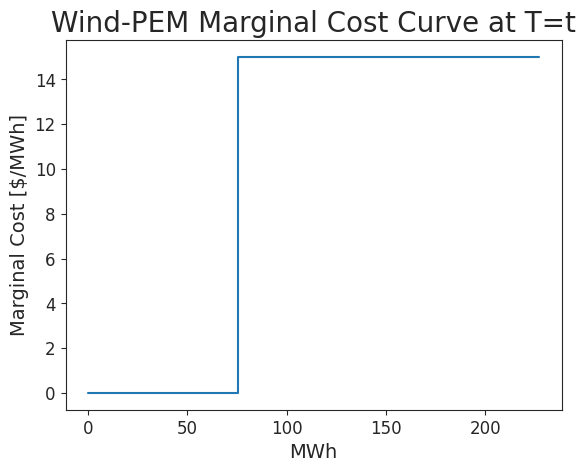

In [3]:
mws = np.linspace(0, 227.05, 10)
m_cost = [0 if mw < (227.05 - 127.05) else 15 for mw in mws]
plt.step(mws, m_cost)
plt.xlabel("MWh")
plt.ylabel("Marginal Cost [$/MWh]")
plt.title("Wind-PEM Marginal Cost Curve at T=t")

In [4]:
import glob
import numpy as np
from dispatches.case_studies.renewables_case.double_loop_utils import read_rts_gmlc_wind_inputs, prescient_outputs_for_gen
from dispatches_sample_data import rts_gmlc
from dispatches.case_studies.renewables_case.load_parameters import wind_cap_cost, wind_op_cost, pem_cap_cost, pem_op_cost, pem_var_cost, PA
from dispatches_data.api import files

rt_revenue_only = True
include_wind_capital_cost = False
shortfall_price = 1000

wind_cf = read_rts_gmlc_wind_inputs(rts_gmlc.source_data_path, gen_name="303_WIND_1", agg_func="first")['303_WIND_1-RTCF']
results_file_pattern = f"RE/input_data/sweep_parameters_15_{shortfall_price}.csv"
params_file = files("dynamic_sweep", pattern=results_file_pattern)
if not params_file:
    raise LookupError(f"No files found with pattern {results_file_pattern}")
params = pd.read_csv(params_file[0])

records = []
csv_files_to_load = files("dynamic_sweep", pattern=f"RE/results_parameter_sweep_15_{shortfall_price}/*.csv")
for filename in csv_files_to_load:
    res = pd.read_csv(filename)
    ind = int(Path(filename).stem.split('_')[-1])
    pem_bid = params['PEM_bid'][ind]
    pem_size = params['PEM_power_capacity'][ind]
    if rt_revenue_only:
        e_revenue =(res["Dispatch"] * res["LMP"]).sum()
    else:
        e_revenue = (res["Dispatch DA"] * res["LMP DA"] + (res["Dispatch"] - res["Dispatch DA"]) * res["LMP"]).sum()
    pem_elec = np.clip(wind_cf.values * 847 - res['Dispatch'], 0, pem_size)
    h2_price = 3
    h_revenue = pem_elec.sum() / 54.953 * h2_price * 1e3
    cap_cost = (847 * wind_cap_cost * int(include_wind_capital_cost) + pem_size * pem_cap_cost) * 1e3 
    fixed_op_cost = (847 * wind_op_cost + pem_size * pem_op_cost) * 1e3
    var_op_cost = pem_var_cost * pem_elec.sum()
    npv = -cap_cost + PA * (e_revenue + h_revenue - fixed_op_cost - var_op_cost)
    records.append({
        "e_revenue": e_revenue,
        "h_revenue": h_revenue,
        "pem_bid": pem_bid,
        "pem_mw": pem_size,
        'NPV': npv})
sweep_results = pd.DataFrame(records)
sweep_results['pem_mw'] = sweep_results['pem_mw'].round(2)
sweep_results['pem_bid_round'] = sweep_results['pem_bid'].astype('int')
sweep_results['pem_mw_round'] = sweep_results['pem_mw'].astype('int')
sweep_results['e_revenue_mil'] = (sweep_results['e_revenue'] * 1e-6)
sweep_results['h_revenue_mil'] = (sweep_results['h_revenue'] * 1e-6)
sweep_results['NPV_bil'] = (sweep_results['NPV'] * 1e-9)
sweep_results['NPV_mil'] = (sweep_results['NPV'] * 1e-6)


In [5]:
# get results file from RE_surrogate_optimization_steadystate.py
re_case_dir = Path.cwd()
results = pd.read_csv(re_case_dir / f"surrogate_results_ss_rt{'_500' if shortfall_price == 500 else '_freewind'}.csv")
results = results.drop(columns=["Unnamed: 0", 'wind_mw'])
results['pem_mw'] = results['pem_mw'].round(2)
results['pem_bid_round'] = results['pem_bid'].astype('int')
results['pem_mw_round'] = results['pem_mw'].astype('int')
results['e_revenue_mil'] = (results['e_revenue'] * 1e-6)
results['h_revenue_mil'] = (results['h_revenue'] * 1e-6)
results['NPV_bil'] = (results['NPV'] * 1e-9)
results['NPV_mil'] = (results['NPV'] * 1e-6)

In [6]:
elec_rev_min = min(results['e_revenue_mil'].min(), sweep_results['e_revenue_mil'].min())
elec_rev_max = max(results['e_revenue_mil'].max(), sweep_results['e_revenue_mil'].max())
h2_rev_min = min(results['h_revenue_mil'].min(), sweep_results['h_revenue_mil'].min())
h2_rev_max = max(results['h_revenue_mil'].max(), sweep_results['h_revenue_mil'].max())
npv_min = min(results['NPV_mil'].min(), sweep_results['NPV_mil'].min())
npv_max = max(results['NPV_mil'].max(), sweep_results['NPV_mil'].max())

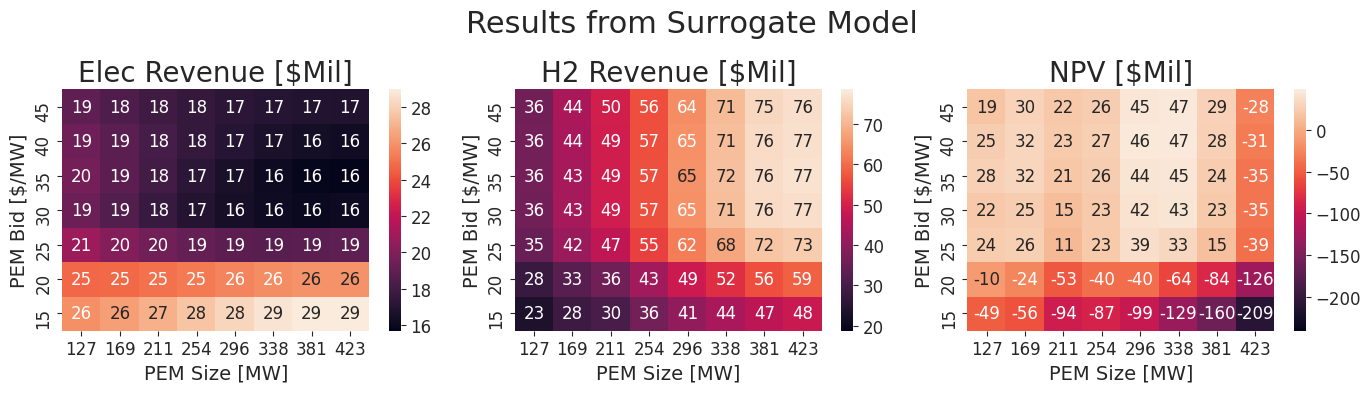

In [7]:
common_bids = set(results['pem_bid'].unique()).intersection(set(sweep_results['pem_bid'].unique()))
common_sizes = set(results['pem_mw'].round(2).unique()).intersection(set(sweep_results['pem_mw'].round(2).unique()))
results = results[(results['pem_bid'].isin(common_bids)) & (results['pem_mw'].round(2).isin(common_sizes))]

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
sns.heatmap(results.pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values='e_revenue_mil',
                                aggfunc='mean'), annot=True, fmt=".0f", ax=axs[0],
                                vmin=elec_rev_min, vmax=elec_rev_max)
axs[0].set_title("Elec Revenue [$Mil]")
axs[0].set_xlabel("PEM Size [MW]")
axs[0].set_ylabel("PEM Bid [$/MW]")

sns.heatmap(results.pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values='h_revenue_mil',
                                aggfunc='mean'), annot=True, fmt=".0f", ax=axs[1],
                                vmin=h2_rev_min, vmax=h2_rev_max)
axs[1].set_title("H2 Revenue [$Mil]")
axs[1].set_xlabel("PEM Size [MW]")
axs[1].set_ylabel("PEM Bid [$/MW]")

sns.heatmap(results.pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values='NPV_mil',
                                aggfunc='mean'), annot=True, fmt=".0f", ax=axs[2],
                                vmin=npv_min, vmax=npv_max)
axs[2].set_title("NPV [$Mil]")
axs[2].set_xlabel("PEM Size [MW]")
axs[2].set_ylabel("PEM Bid [$/MW]")

for ax in axs:
    ax.invert_yaxis()

fig.suptitle("Results from Surrogate Model")
fig.tight_layout(rect=[0, 0., 1, 0.90])

## Compare with Input Dataset from Prescient Sweep

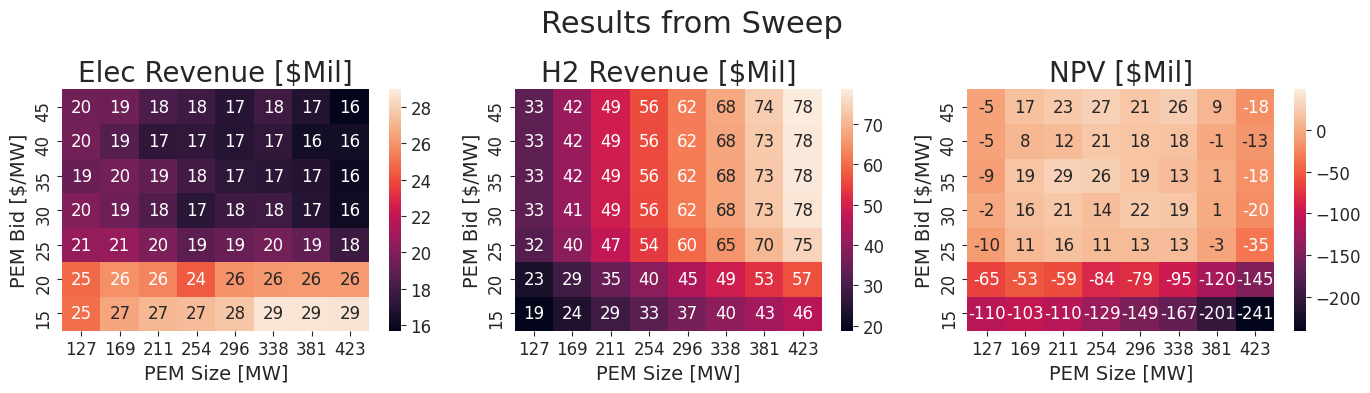

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
sns.heatmap(sweep_results.pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values='e_revenue_mil',
                                aggfunc='mean'), annot=True, fmt=".0f", ax=axs[0],
                                vmin=elec_rev_min, vmax=elec_rev_max)
axs[0].set_title("Elec Revenue [$Mil]")
axs[0].set_xlabel("PEM Size [MW]")
axs[0].set_ylabel("PEM Bid [$/MW]")

sns.heatmap(sweep_results.pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values='h_revenue_mil',
                                aggfunc='mean'), annot=True, fmt=".0f", ax=axs[1],
                                vmin=h2_rev_min, vmax=h2_rev_max)
axs[1].set_title("H2 Revenue [$Mil]")
axs[1].set_xlabel("PEM Size [MW]")
axs[1].set_ylabel("PEM Bid [$/MW]")

sns.heatmap(sweep_results.pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values='NPV_mil',
                                aggfunc='mean'), annot=True, fmt=".0f", ax=axs[2],
                                vmin=npv_min, vmax=npv_max)
axs[2].set_title("NPV [$Mil]")
axs[2].set_xlabel("PEM Size [MW]")
axs[2].set_ylabel("PEM Bid [$/MW]")

for ax in axs:
    ax.invert_yaxis()

fig.suptitle("Results from Sweep")
fig.tight_layout(rect=[0, 0., 1, 0.90])

e_revenue_mil -0.09462143144768442 0.07274155190226542 -0.014745430413946155
h_revenue_mil -0.02562738265655595 0.2366553626869596 0.05163207862224956
NPV_mil -20.290197305289617 22.285299190905906 0.13405520351218816


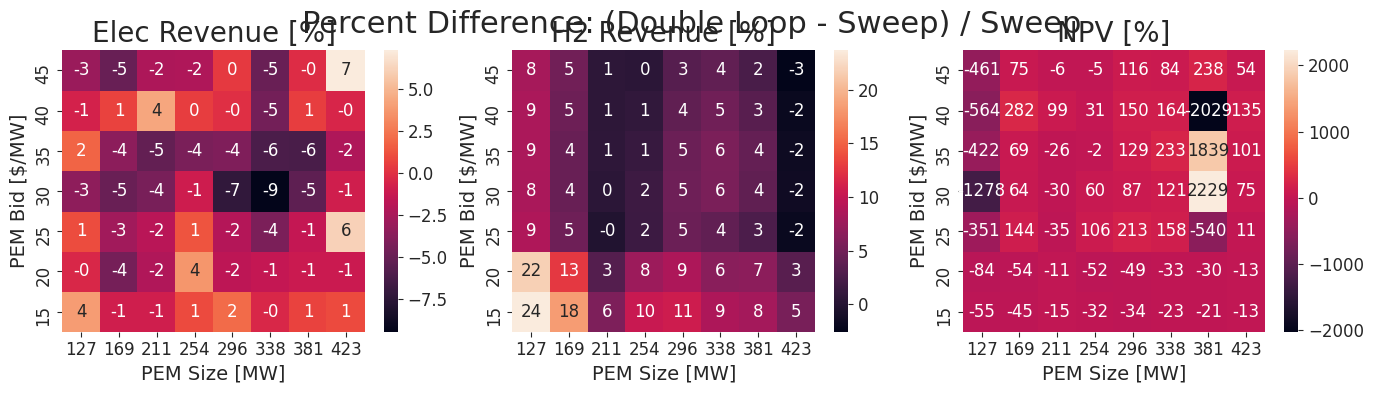

In [9]:
def calc_diff_df(value):
    sweep_diff = sweep_results[(sweep_results['pem_bid'].isin(common_bids)) & (sweep_results['pem_mw'].isin(common_sizes))].pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values=value,
                                aggfunc='mean')
    diff_df = (results[(results['pem_bid'].isin(common_bids)) & (results['pem_mw'].isin(common_sizes))].pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values=value,
                                aggfunc='mean') - sweep_diff) / sweep_diff
    print(value, min(diff_df.min()), max(diff_df.max()), diff_df.values.flatten().mean())
    return diff_df * 1e2

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
sns.heatmap(calc_diff_df('e_revenue_mil'), annot=True, fmt=".0f", ax=axs[0])
axs[0].set_title("Elec Revenue [%]")
axs[0].set_xlabel("PEM Size [MW]")
axs[0].set_ylabel("PEM Bid [$/MW]")

sns.heatmap(calc_diff_df('h_revenue_mil'), annot=True, fmt=".0f", ax=axs[1])
axs[1].set_title("H2 Revenue [%]")
axs[1].set_xlabel("PEM Size [MW]")
axs[1].set_ylabel("PEM Bid [$/MW]")

sns.heatmap(calc_diff_df('NPV_mil'), annot=True, fmt=".0f", ax=axs[2])
axs[2].set_title("NPV [%]")
axs[2].set_xlabel("PEM Size [MW]")
axs[2].set_ylabel("PEM Bid [$/MW]")

for ax in axs:
    ax.invert_yaxis()

plt.suptitle("Percent Difference: (Double Loop - Sweep) / Sweep")
plt.tight_layout()

e_revenue_mil -1.690874519190146 1.1414322871002351 -0.2771110723161043
h_revenue_mil -2.011101931908186 4.978020625229789 2.0586346296886378
NPV_mil -18.033667341989695 61.116926418569555 20.056006229577765


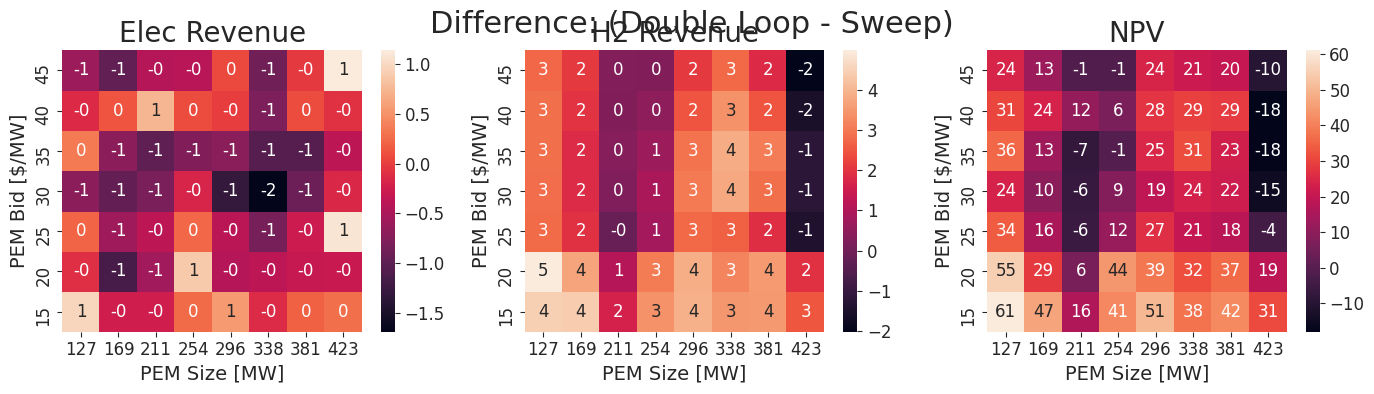

In [10]:
def calc_diff_df(value):
    sweep_diff = sweep_results[(sweep_results['pem_bid'].isin(common_bids)) & (sweep_results['pem_mw'].isin(common_sizes))].pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values=value,
                                aggfunc='mean')
    diff_df = results[(results['pem_bid'].isin(common_bids)) & (results['pem_mw'].isin(common_sizes))].pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values=value,
                                aggfunc='mean')
    diff_df -= sweep_diff
    print(value, min(diff_df.min()), max(diff_df.max()), diff_df.values.flatten().mean())
    return diff_df

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
sns.heatmap(calc_diff_df('e_revenue_mil'), annot=True, fmt=".0f", ax=axs[0])
axs[0].set_title("Elec Revenue")
axs[0].set_xlabel("PEM Size [MW]")
axs[0].set_ylabel("PEM Bid [$/MW]")

sns.heatmap(calc_diff_df('h_revenue_mil'), annot=True, fmt=".0f", ax=axs[1])
axs[1].set_title("H2 Revenue")
axs[1].set_xlabel("PEM Size [MW]")
axs[1].set_ylabel("PEM Bid [$/MW]")

sns.heatmap(calc_diff_df('NPV_mil'), annot=True, fmt=".0f", ax=axs[2])
axs[2].set_title("NPV")
axs[2].set_xlabel("PEM Size [MW]")
axs[2].set_ylabel("PEM Bid [$/MW]")

for ax in axs:
    ax.invert_yaxis()

plt.suptitle("Difference: (Double Loop - Sweep)")
plt.tight_layout()

## Check Revenue of Optimal Model run through Double Loop

In [11]:
for run_type in ['optimal', 'sweep']:
    run_file = Path(f"{run_type}_design_15_shortfall_{shortfall_price}_rth_1")
    run_df = prescient_outputs_for_gen(run_file, rts_gmlc.source_data_path, "303_WIND_1")
    if run_type == 'optimal':
        pem_bid = 40.8
        pem_size = 317.4
    else:
        pem_bid = 35
        pem_size = 211.75

    if rt_revenue_only:
        e_revenue =(run_df["Dispatch"] * run_df["LMP"]).sum()
    else:
        e_revenue = (run_df["Dispatch DA"] * run_df["LMP DA"] + (run_df["Dispatch"] - run_df["Dispatch DA"]) * run_df["LMP"]).sum()
    pem_elec = np.clip(wind_cf.values[:8760] * 847 - run_df['Dispatch'], 0, pem_size)
    h2_price = 3
    h_revenue = pem_elec.sum() / 54.953 * h2_price * 1e3
    cap_cost = (847 * wind_cap_cost * int(include_wind_capital_cost) + pem_size * pem_cap_cost) * 1e3 
    fixed_op_cost = (847 * wind_op_cost + pem_size * pem_op_cost) * 1e3
    var_op_cost = pem_var_cost * pem_elec.sum()
    npv = -cap_cost + PA * (e_revenue + h_revenue - fixed_op_cost - var_op_cost)
    print(run_type, {
        "e_revenue": e_revenue,
        "h_revenue": h_revenue,
        'NPV': npv})

optimal {'e_revenue': 19327961.771614905, 'h_revenue': 67913964.9653522, 'NPV': 74248164.74960607}
sweep {'e_revenue': 20830121.123166505, 'h_revenue': 51435875.02247375, 'NPV': 75250235.95798433}


## Compare day frequencies

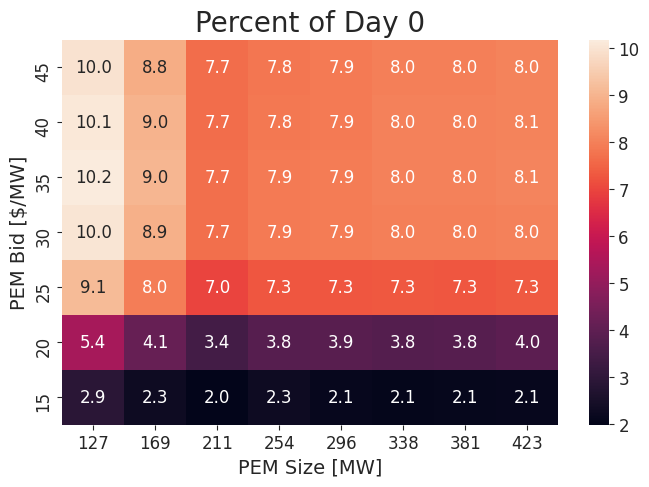

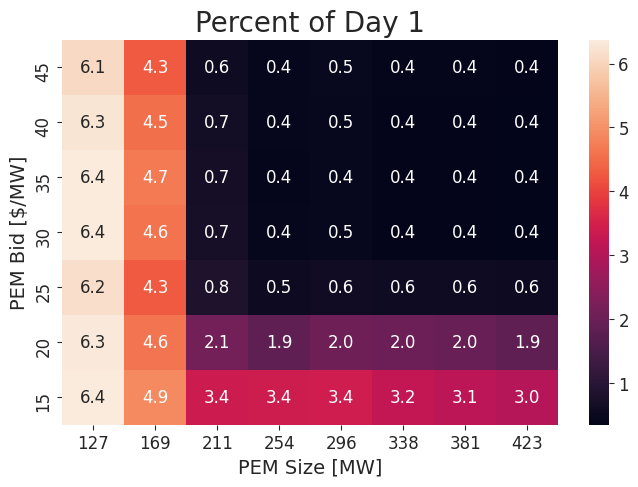

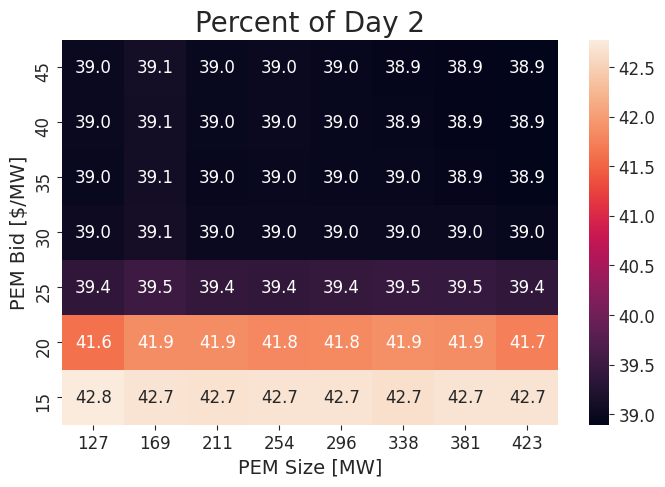

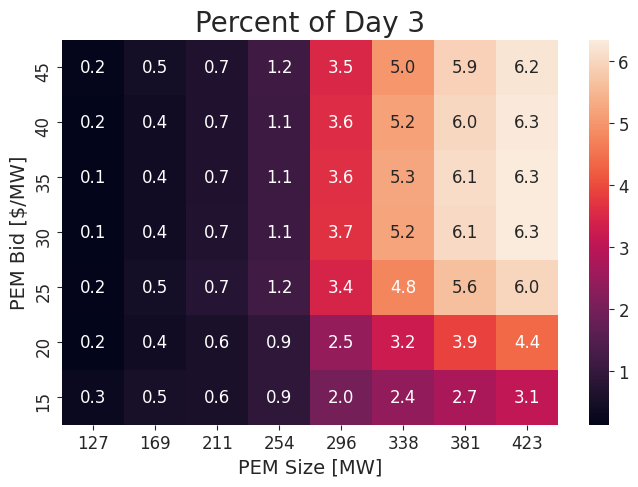

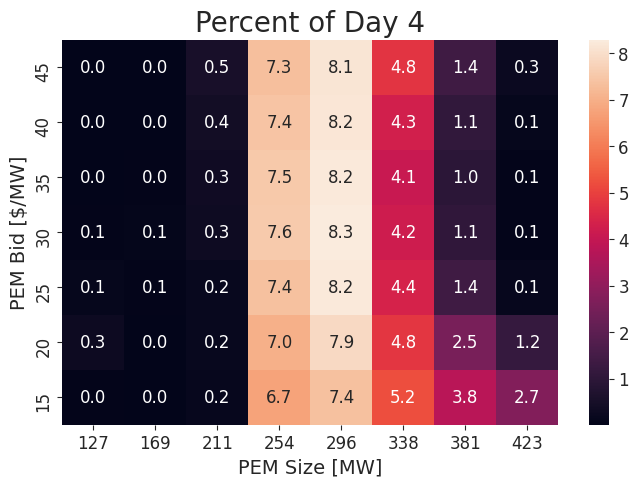

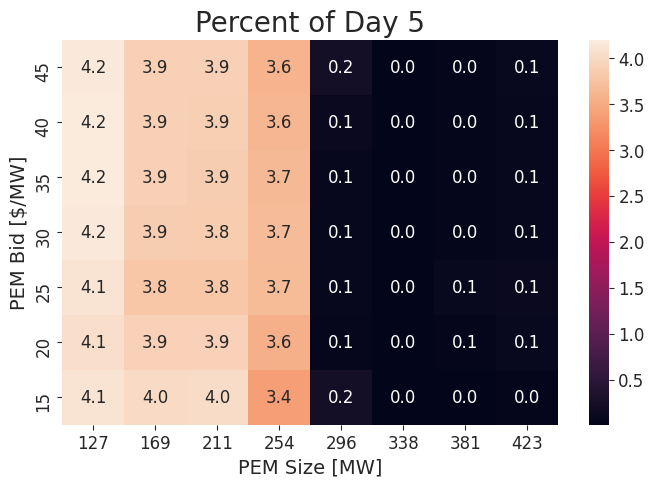

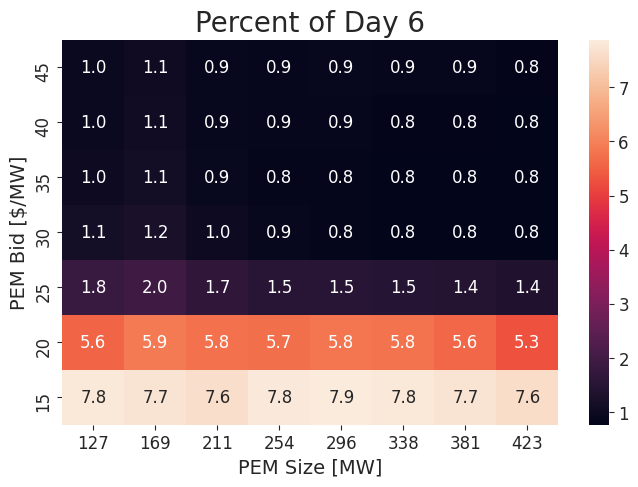

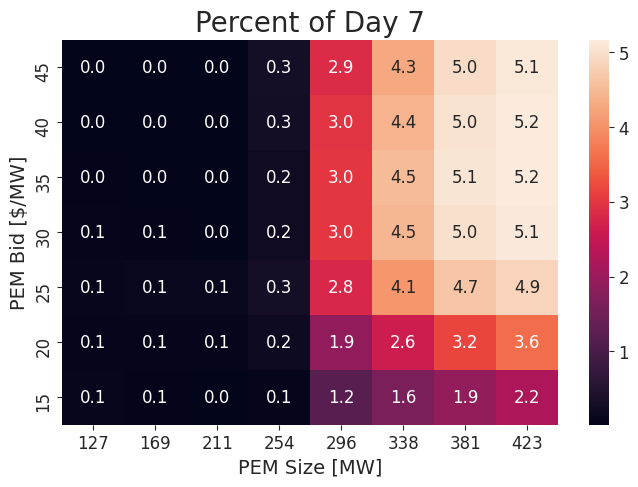

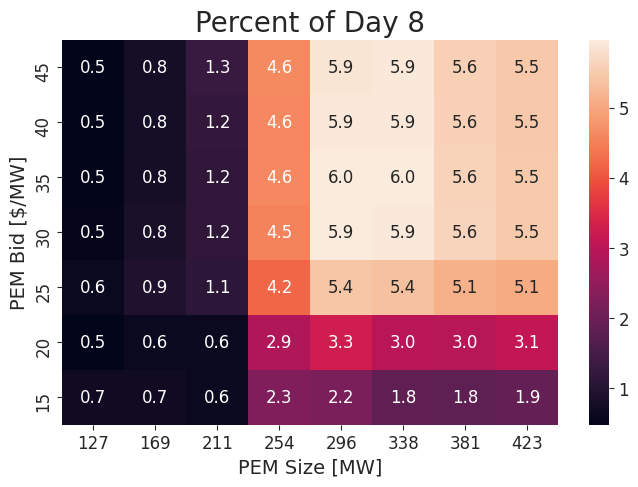

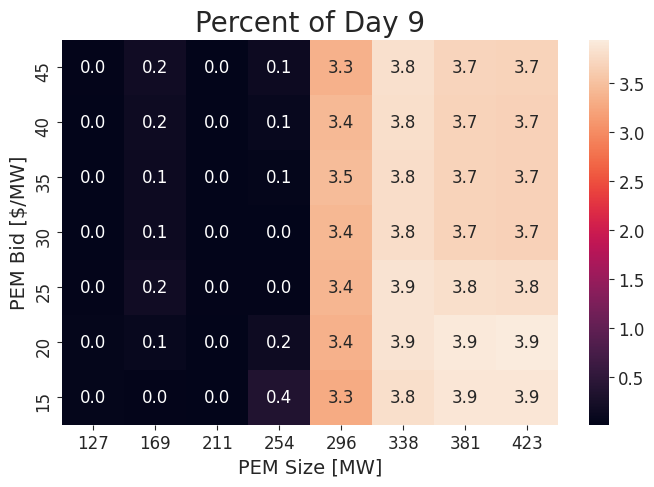

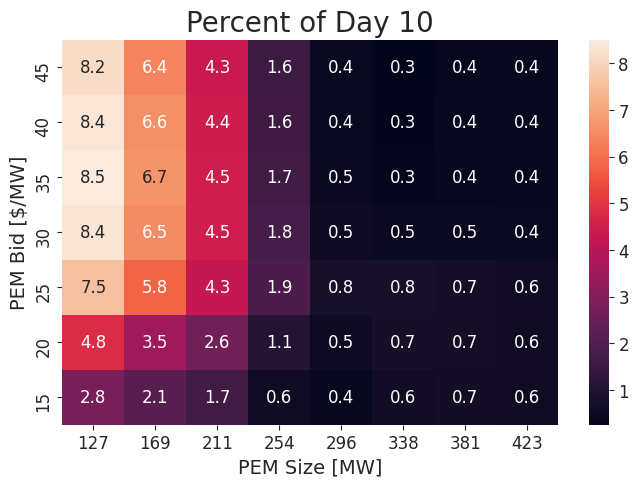

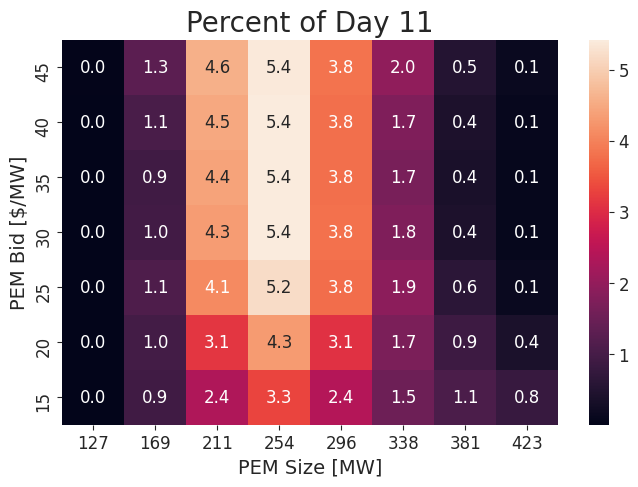

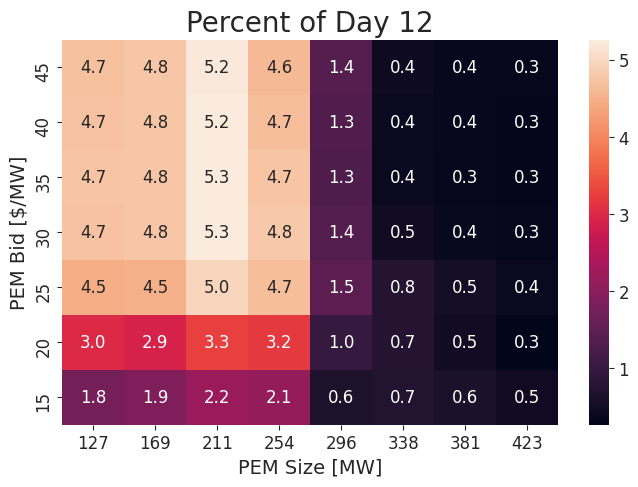

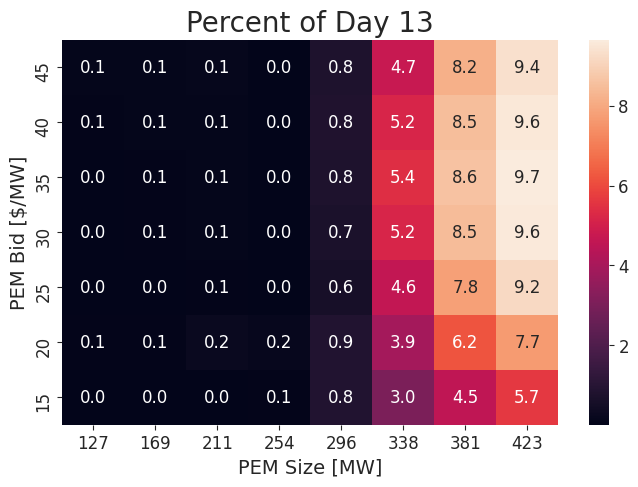

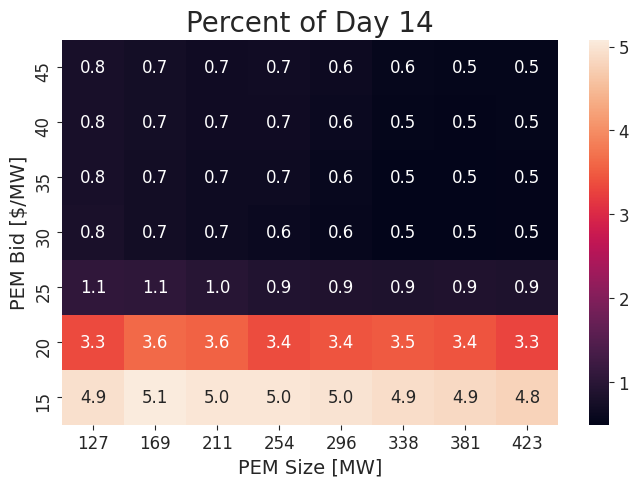

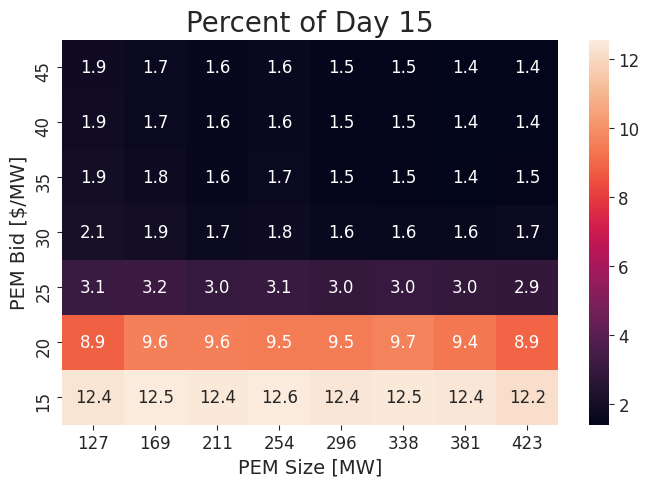

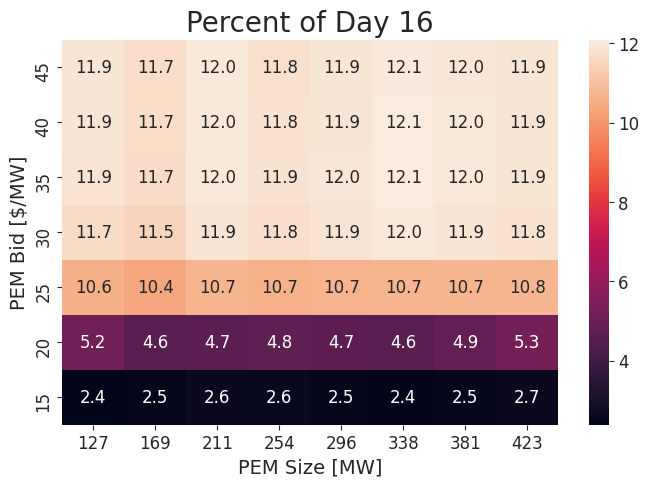

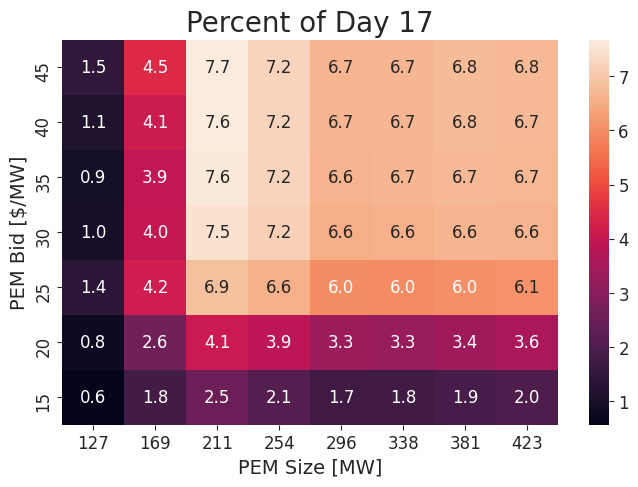

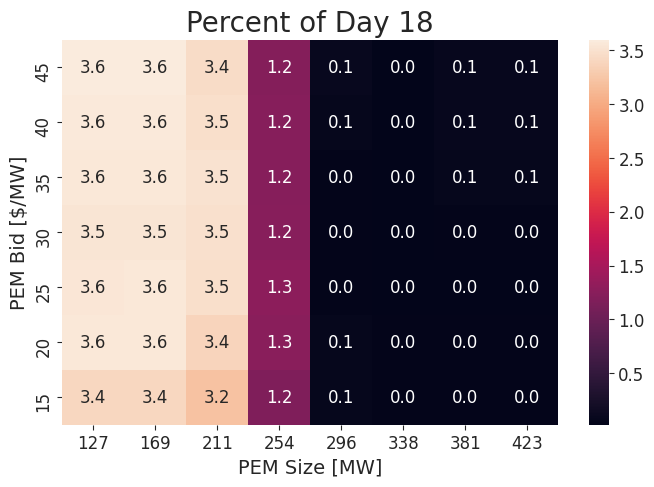

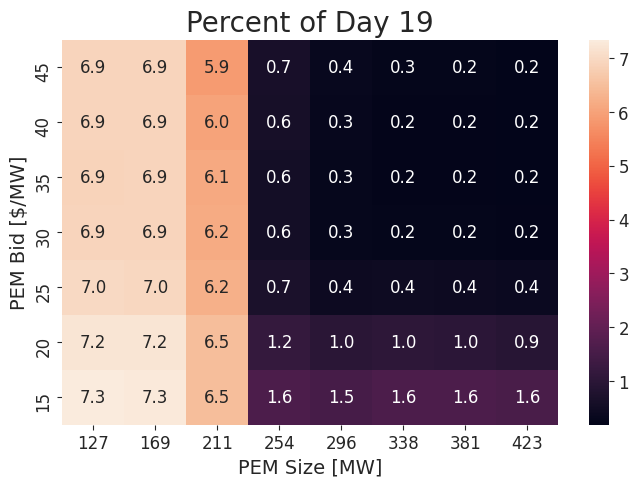

In [12]:
for day in range(20):
    results[f'percent_day_{day}'] = results[f'freq_day_{day}'] * 1e2
    fig, axs = plt.subplots(1, 1, figsize=(8, 5))
    sns.heatmap(results.pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values=f'percent_day_{day}',
                                aggfunc='mean'), annot=True, fmt=".1f", ax=axs)
    axs.set_title(f"Percent of Day {day}")
    axs.set_xlabel("PEM Size [MW]")
    axs.set_ylabel("PEM Bid [$/MW]")
    axs.invert_yaxis()